# Using _egobox_ surrogate model _Gpx_

## Installation

In [1]:
%pip install egobox

Note: you may need to restart the kernel to use updated packages.


We import _egobox_ as _egx_ for short

In [2]:
import egobox as egx

# Example 1 : Gpx basics

### Training 

#### Training data definition

In [3]:
import numpy as np

xt = np.array([[0.0, 1.0, 2.0, 3.0, 4.0]]).T
yt = np.array([[0.0, 1.0, 1.5, 0.9, 1.0]]).T

#### Building the surrogate

In [4]:
gpx = egx.Gpx.builder().fit(xt, yt)

### Prediction

#### Using the surrogate for estimation

In [5]:
# number of x locations to estimate
num = 100

# x should have 2D shape (nsamples, nx)
x = np.linspace(0.0, 4.0, num).reshape((-1, 1))

# estimated values
y = gpx.predict(x)
# estimated variances
s2 = gpx.predict_var(x)

# Print hyperparameters
print(f"Optimal theta = {gpx.thetas()[0]}")
print(f"GP variance = {gpx.variances()[0]}")
print(f"Reduced likelihood = {gpx.likelihoods()[0]}")

Optimal theta = [1.67828994]
GP variance = 0.3049400437701594
Reduced likelihood = 0.5781740714718056


#### Plotting results

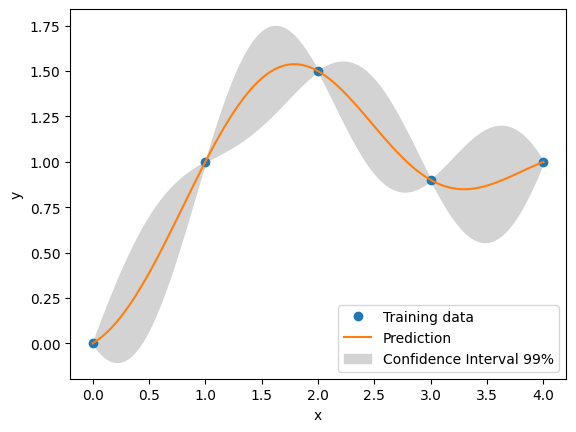

In [6]:
import matplotlib.pyplot as plt

def plot_gp(xt, yt, x, y, s2):
    fig, axs = plt.subplots(1)
    
    # training data
    axs.plot(xt, yt, "o")
    
    # gp mean
    axs.plot(x, y)
    
    # 99% confidence interval
    axs.fill_between(
        np.ravel(x),
        np.ravel(y - 3 * np.sqrt(s2)),
        np.ravel(y + 3 * np.sqrt(s2)),
        color="lightgrey",
    )
    
    # legend
    axs.set_xlabel("x")
    axs.set_ylabel("y")
    axs.legend(
        ["Training data", "Prediction", "Confidence Interval 99%"],
        loc="lower right",
    )
    return axs

plot_gp(xt, yt, x, y, s2)
plt.show()

### Sampling

#### Sampling the conditionned Gaussian process

In [7]:
# number fo trajectories to sample
n_traj = 30

trajs = gpx.sample(x, n_traj)

#### Plotting trajectories

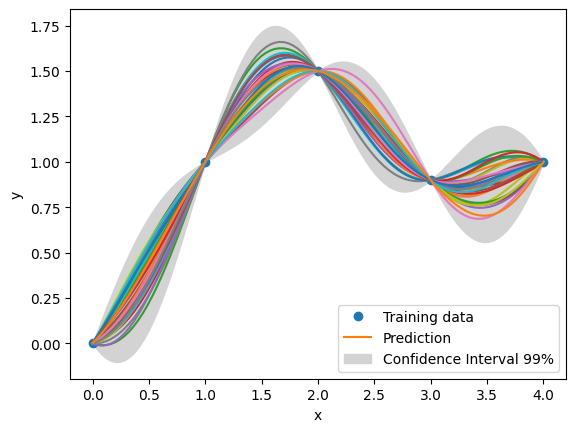

In [8]:
axs = plot_gp(xt, yt, x, y, s2)

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## Example 2 : Gpx trend and correlation models customization, saving and loading

### Test function

$$f : \left\{ \begin{array}{c} [-10, 10] \rightarrow \mathbb{R} \\ x \mapsto x^2 \sin(x) \ \end{array} \right.$$

In [9]:
import numpy as np

def f(x):
    return x**2 * np.sin(x)

### Training

$f$ is approximated with _Gpx_ at points $-8.5$,  $-4.0$,  $-3.0$,  $-1.0$, $4.0$ and  $7.5$. 

In [10]:
xt = np.array([[-8.5, -4.0, -3.0, -1.0, 4.0, 7.5]]).T
yt = f(xt)

To show features of _Gpx_, below, we build the surrogate asking for best GP regression by testing constant, linear or quadratic trend with either squared_exponential or matern52. The quality of the surrogate is assessed by cross validation.

In [11]:
gpx_builder = egx.Gpx.builder(regr_spec=egx.RegressionSpec.ALL, 
                              corr_spec=egx.CorrelationSpec.SQUARED_EXPONENTIAL | egx.CorrelationSpec.MATERN52)
gpx = gpx_builder.fit(xt, yt)

We can get string representations of the trained GP

In [12]:
print(f"Gpx string: {gpx}")
print(f"Gpx stringified JSON serialization {repr(gpx)}")

Gpx string: Mixture[Smooth](Linear_SquaredExponentialGP(mean=LinearMean, corr=SquaredExponential, theta=[14.453108310585526], variance=441.2131727575699, likelihood=3.0317685650605943))
Gpx stringified JSON serialization {"recombination":{"Smooth":null},"experts":[{"type":"GpLinearSquaredExponentialSurrogate","theta":{"v":1,"dim":[1],"data":[14.453108310585526]},"likelihood":3.0317685650605943,"inner_params":{"sigma2":441.2131727575699,"beta":{"v":1,"dim":[2,1],"data":[-0.07757161926025721,0.7944037941949736]},"gamma":{"v":1,"dim":[6,1],"data":[-0.44643167687202573,1.133131124809854,-0.3878666745284213,0.15533955394250828,-0.8959677803782301,0.4417954530263136]},"r_chol":{"v":1,"dim":[6,6],"data":[1.000000000000011,0.0,0.0,0.0,0.0,0.0,0.0001510561378024045,0.9999999885910327,0.0,0.0,0.0,0.0,1.9601672565991523e-6,0.6476128837840273,0.7619695221943696,0.0,0.0,0.0,2.434980514598138e-11,0.020037303823239316,0.21381693649172018,0.9766682262287502,0.0,0.0,3.296423703753802e-30,8.398281535208

... and save it in a json file (for a human readable format) or in binary file (for optimizing performances).

In [13]:
gpx.save("gp.json")  # json extension is automatically detected hence json file format
gpx.save("gp.bin")   # otherwise binary (you can compare here the size on disk)

True

We can reload it with

In [14]:
gpx = egx.Gpx.load("gp.json")

### Prediction

In [15]:
x_min, x_max = -10, 10
n_plot = 500

# x must have (nsamples, nx) shape
x = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

y = gpx.predict(x)
s2 = gpx.predict_var(x)

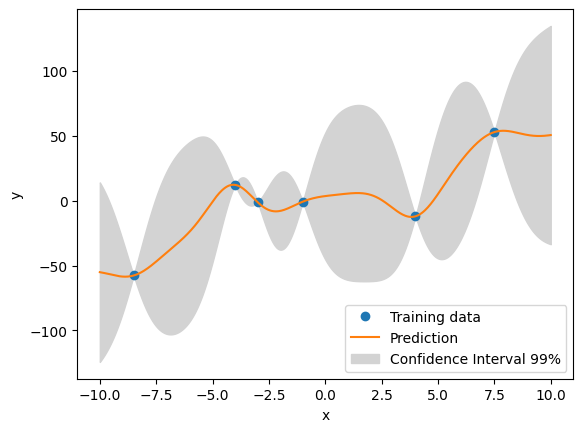

In [16]:
plot_gp(xt, yt, x, y, s2)
plt.show()

### Sampling

#### Sampling the conditionned Gaussian process

In [17]:
# number fo trajectories to sample
n_traj = 10

trajs = gpx.sample(x, n_traj)

#### Plotting trajectories

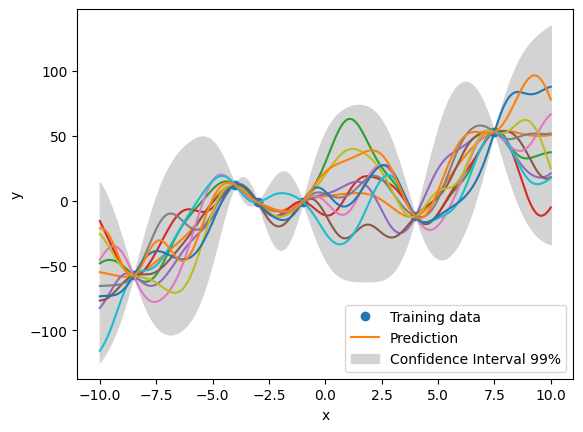

In [18]:
axs = plot_gp(xt, yt, x, y, s2)

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## Example 3 : Clustering

### Test function

We are going to use a test function with three modes to show clustering feature

In [19]:
def function_3modes(x):
    y = np.zeros(x.shape)
    y[x < 0.4] = x[x < 0.4] ** 2
    y[(x >= 0.4) & (x < 0.8)] = 3 * x[(x >= 0.4) & (x < 0.8)] + 1
    y[x >= 0.8] = np.sin(10 * x[x >= 0.8])
    return y

### Training 

#### Training data definition

In [20]:
np.random.seed(42)  # results may differ depending on training data, set seed here for reproducibility
xt = np.random.sample(60).reshape((-1, 1))
yt = function_3modes(xt)

#### Building the surrogate

In [21]:
gpx = egx.Gpx.builder(n_clusters=3).fit(xt, yt)

In [22]:
print(gpx)

Mixture[Smooth(0.1)](Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.030558468159793944], variance=0.9805836846291843, likelihood=89.03681533053401), Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.027856606714033984], variance=0.026494441460099966, likelihood=278.25736821645546), Constant_SquaredExponentialGP(mean=ConstantMean, corr=SquaredExponential, theta=[0.007858695608853907], variance=1.4186216960244649, likelihood=192.5430848398401))


We see that 3 experts are smoothly recombined with an heasviside factor of 0.1 automatically adjusted to improve the overall surrogate quality.

### Plotting

In [23]:
x_min, x_max = 0, 1
n_plot = 500

# x must have (nsamples, nx) shape
x = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

y = gpx.predict(x)
s2 = gpx.predict_var(x)

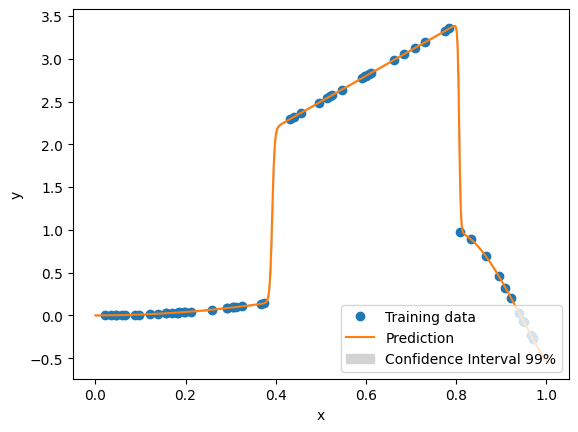

In [24]:
plot_gp(xt, yt, x, y, s2)
plt.show()

We can check it is better than one cluster (the default).

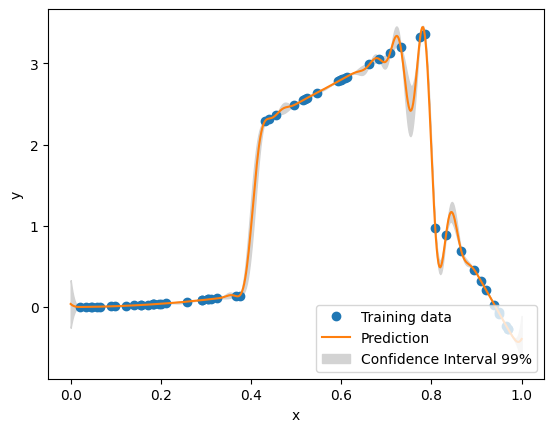

In [25]:
gpx = egx.Gpx.builder().fit(xt, yt)
y = gpx.predict(x)
s2 = gpx.predict_var(x)
plot_gp(xt, yt, x, y, s2)
plt.show()

We can also let _Gpx_ find the  best number of clusters

In [26]:
gpx = egx.Gpx.builder(n_clusters=0).fit(xt, yt)
print(gpx)
y = gpx.predict(x)
s2 = gpx.predict_var(x)
plot_gp(xt, yt, x, y, s2)
plt.show()

PanicException: index out of bounds: the len is 0 but the index is 0

## Gpx API

In [ ]:
help(egx.Gpx.builder())

Help on GpMix in module builtins object:

class GpMix(object)
 |  GpMix(n_clusters=1, regr_spec=Ellipsis, corr_spec=Ellipsis, recombination=Ellipsis, theta_init=None, theta_bounds=None, kpls_dim=None, n_start=10, seed=None)
 |  
 |  Gaussian processes mixture builder
 |  
 |  n_clusters (int >= 0)
 |      Number of clusters used by the mixture of surrogate experts.
 |      When set to 0, the number of cluster is determined automatically and refreshed every
 |      10-points addition (should say 'tentative addition' because addition may fail for some points
 |      but failures are counted anyway).
 |  
 |  regr_spec (RegressionSpec flags, an int in [1, 7]):
 |      Specification of regression models used in mixture.
 |      Can be RegressionSpec.CONSTANT (1), RegressionSpec.LINEAR (2), RegressionSpec.QUADRATIC (4) or
 |      any bit-wise union of these values (e.g. RegressionSpec.CONSTANT | RegressionSpec.LINEAR)
 |  
 |  corr_spec (CorrelationSpec flags, an int in [1, 15]):
 |      Sp

In [ ]:
help(egx.Gpx)

Help on class Gpx in module builtins:

class Gpx(object)
 |  A trained Gaussian processes mixture
 |  
 |  Methods defined here:
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __str__(self, /)
 |      Return str(self).
 |  
 |  likelihoods(self, /)
 |      Get reduced likelihood values gotten when fitting the GP experts
 |      
 |      Maybe used to compare various parameterization
 |      
 |      Returns
 |          likelihood as an array[n_clusters]
 |  
 |  predict(self, /, x)
 |      Predict output values at nsamples points.
 |      
 |      Parameters
 |          x (array[nsamples, nx])
 |              input values
 |      
 |      Returns
 |          the output values at nsamples x points (array[nsamples, 1])
 |  
 |  predict_gradients(self, /, x)
 |      Predict surrogate output derivatives at nsamples points.
 |      
 |      Parameters
 |          x (array[nsamples, nx])
 |              input values
 |      
 |      Returns
 |          the output derivatives 